In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pandas as pd
import numpy as np

In [3]:
PATH = "data/dogbreed/"
# size of images 224x224
sz = 224

arch = inception_4

# batch size
bs = 58

!ls {PATH}

299_resnext101_64_no_val_submission.csv  labels.csv.zip		test.zip
299_resnext101_64_val_submission.csv	 models			tmp
340_resnext101_64_no_val_submission.csv  sample_submission.csv	train
labels.csv				 test			train.zip


In [4]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1

val_idxs = [0]

### Initial model

In [5]:
# Helps us itterate faster by changing images from small to big
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [6]:
# Load our data sets
%time data = get_data(sz, bs)

# Create our simple model, no data augmentation.
# Precomputing weigths
learn = ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


CPU times: user 272 ms, sys: 12 ms, total: 284 ms
Wall time: 282 ms
100%|██████████| 1/1 [00:00<00:00, 32.35it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.75016    0.050805   1.0       
    1      0.52653    0.013001   1.0                         
    2      0.46036    0.020913   1.0                         
    3      0.386188   0.010467   1.0                         
    4      0.342414   0.001537   1.0                         

CPU times: user 9.21 s, sys: 8.31 s, total: 17.5 s
Wall time: 12.5 s


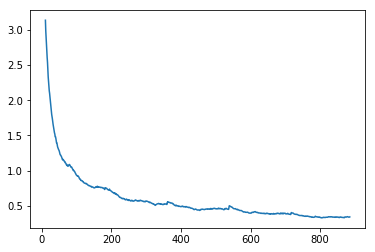

In [7]:
# Training is very fast with precomputed weights
%time learn.fit(1e-1,5)

# Plot loss training
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.403046   0.001422   1.0       
    1      0.399391   0.001262   1.0                         
    2      0.428365   0.001371   1.0                         
    3      0.36136    0.001431   1.0                         
    4      0.386112   0.00145    1.0                         

CPU times: user 8min 54s, sys: 1min 29s, total: 10min 24s
Wall time: 4min 45s


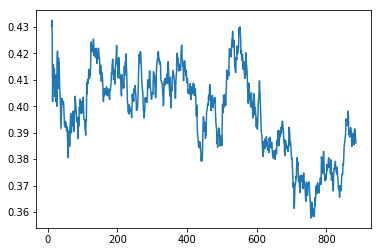

In [8]:
# Usign cycle_len=1 means stochastic gradient descent with restarts used only once during the training.
# Disable precompute and train all conv layers
learn.precompute = False

%time learn.fit(1e-3, 5, cycle_len=1)

# Plot loss 
learn.sched.plot_loss()

# Save our model in models folder
learn.save('224_inception_4_V2')

### Increase the size of images to improve accuracy 299 x 299

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.245677   0.000189   1.0       
    1      0.227168   0.000186   1.0                         
    2      0.223996   0.000212   1.0                         
    3      0.251984   0.00016    1.0                         
    4      0.219909   0.000185   1.0                         
    5      0.223693   0.000127   1.0                         
    6      0.197046   0.000144   1.0                         

CPU times: user 20min 36s, sys: 3min 51s, total: 24min 28s
Wall time: 12min 34s


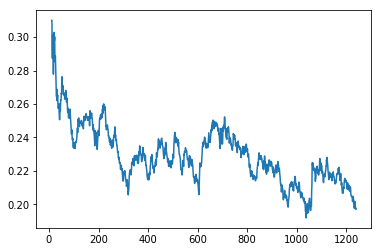

In [9]:
# Set image size to 299 and augment images and continue training 
learn.set_data(get_data(299, bs))

%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

# Plot loss
learn.sched.plot_loss()

learn.save('299_inception_4_V2')

##### Retrain our model on all training data (no validation), images 360x360

In [10]:
bs = 40

### Retrain our model on all training data (no validation), images 400x400,  UNFREEZING all layers.

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.206475   9.1e-05    1.0       
    1      0.211397   0.00012    1.0                         
    2      0.209203   0.000121   1.0                         
    3      0.227957   0.000148   1.0                         
    4      0.217235   9.2e-05    1.0                         
    5      0.225986   0.000115   1.0                         
    6      0.199018   9e-05      1.0                         

CPU times: user 43min 54s, sys: 4min 32s, total: 48min 27s
Wall time: 24min 1s


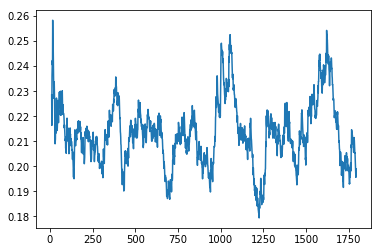

In [12]:
# Get data without validation set and images 400x400 and bs 58
learn.set_data(get_data(400, bs))

%time learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

learn.save('400_inception_4_V2')

### Make our prediction file using all training images 400 x 400 

In [13]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('400_inception_4_V2')

%time log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

CPU times: user 4min 42s, sys: 32 s, total: 5min 14s
Wall time: 3min 7s


(10357, 120)

In [14]:
# Convert to probs
preds = np.exp(log_preds_test)

df = pd.DataFrame(preds)
df.columns = data.classes

df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,1.865958e-05,7.712234e-05,6.305850e-05,1.141065e-05,3.996236e-06,2.779701e-06,1.994238e-05,3.325056e-06,8.025273e-06,...,1.472761e-06,9.287354e-06,6.302552e-06,3.044984e-06,5.541760e-05,7.419814e-06,3.166735e-06,1.387859e-05,0.000031,1.218593e-05
1,6b423ca7020e70eb05732843c5d2bad1,4.144530e-05,3.050031e-05,4.365623e-05,1.004669e-05,5.360874e-07,3.450975e-06,3.997211e-06,4.324894e-06,3.249543e-06,...,8.520662e-06,8.066589e-07,1.980729e-06,6.224062e-07,1.474454e-05,3.967788e-06,4.247926e-06,3.474113e-06,0.000023,2.855041e-06
2,74aa7e201e0e93e13e87b986a7d31839,4.379008e-07,3.927212e-07,4.267585e-07,1.805038e-04,7.737067e-07,2.397834e-06,9.453264e-07,1.556314e-07,1.076620e-07,...,3.079438e-06,2.799592e-07,3.220442e-07,3.931889e-07,2.517844e-07,1.188630e-06,1.574450e-07,1.290513e-06,0.017164,7.542918e-07
3,a079f72193264bc5685e5d28d7372680,2.534182e-05,2.160794e-05,2.485574e-05,6.678330e-05,1.895038e-06,1.352355e-05,2.610672e-06,6.411921e-06,3.666918e-06,...,3.843317e-05,4.009238e-06,1.650225e-06,8.776046e-07,1.283125e-05,2.131858e-06,1.415162e-04,2.280009e-06,0.000026,2.239073e-05
4,583f7580fa5fec1266331fcf83b76fd6,5.702092e-08,3.564339e-08,3.447868e-09,6.259319e-07,1.415432e-08,6.028355e-08,1.168206e-09,2.025062e-08,6.601012e-10,...,2.111138e-07,9.395759e-09,2.858541e-09,2.502605e-10,3.661505e-08,3.139828e-09,4.728415e-09,6.783853e-07,0.000003,1.157224e-08


In [15]:
# compression="gzip"
df.to_csv(f'{PATH}400_inception_4_V2_submission.csv', index=False)

In [16]:
FilleLink(f'{PATH}400_inception_4_V2_submission.csv')

NameError: name 'FilleLink' is not defined

In [17]:
learn.load('299_inception_4_V2')
%time log_preds_test = learn.predict(is_test=True)
# Convert to probs
preds = np.exp(log_preds_test)
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
df.head()
# compression="gzip"
df.to_csv(f'{PATH}299_inception_4_V2_submission.csv', index=False)
# FilleLink(f'{PATH}299_inception_4_V2_submission.csv')

CPU times: user 4min 41s, sys: 20.1 s, total: 5min 1s
Wall time: 2min 57s
